In [1]:
import scgen
import scanpy as sc

Reading train and validation data

In [3]:
train = sc.read("./tests/data/train_kang.h5ad", backup_url="https://goo.gl/33HtVh")
validation = sc.read("./tests/data/valid_kang.h5ad", backup_url="https://goo.gl/8pdXiQ")

UMAP Visualization of the data train and validation data 

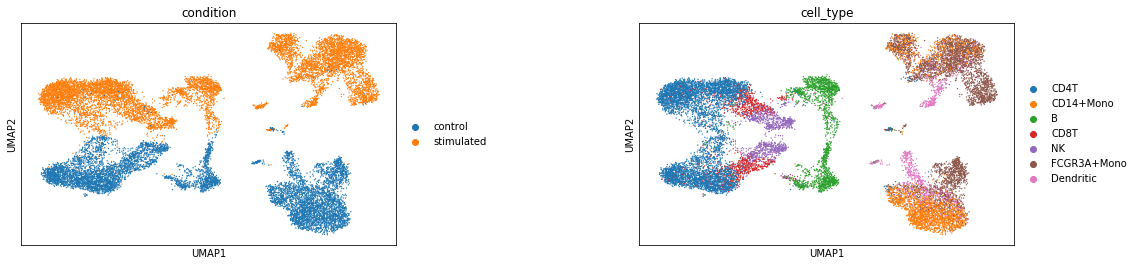

In [4]:
sc.pp.neighbors(train)
sc.tl.umap(train)
sc.pl.umap(train, color=["condition", "cell_type"], wspace=.5)

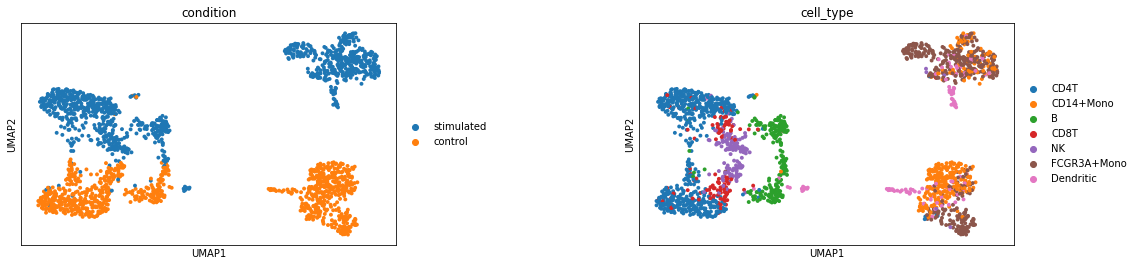

In [5]:
sc.pp.neighbors(validation)
sc.tl.umap(validation)
sc.pl.umap(validation, color=["condition", "cell_type"],  wspace=.5)

Let's remove stimulated CD4T cells from both the training and validation set. This is just for the sake
of this notebook, in practice, you do not need to do this step, just pass the train and validation (if you have one)

In [6]:
train_new = train[~((train.obs["cell_type"]=="CD4T") &(train.obs["condition"]=="stimulated"))]
validation_new = validation[~((validation.obs["cell_type"]=="CD4T") &(validation.obs["condition"]=="stimulated"))]

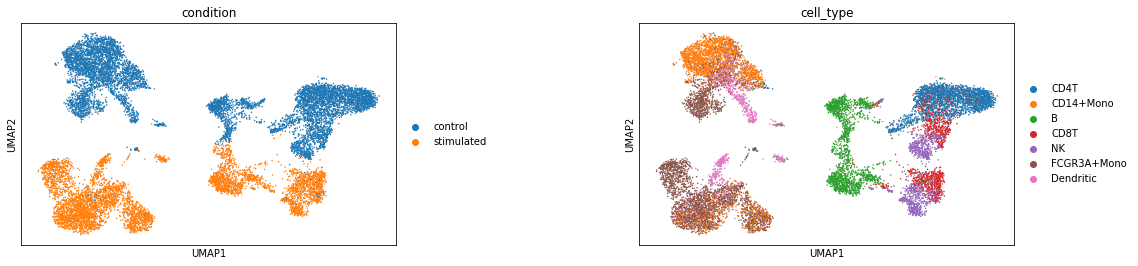

In [7]:
sc.pp.neighbors(train_new)
sc.tl.umap(train_new)
sc.pl.umap(train_new, color=["condition", "cell_type"],  wspace=.5)

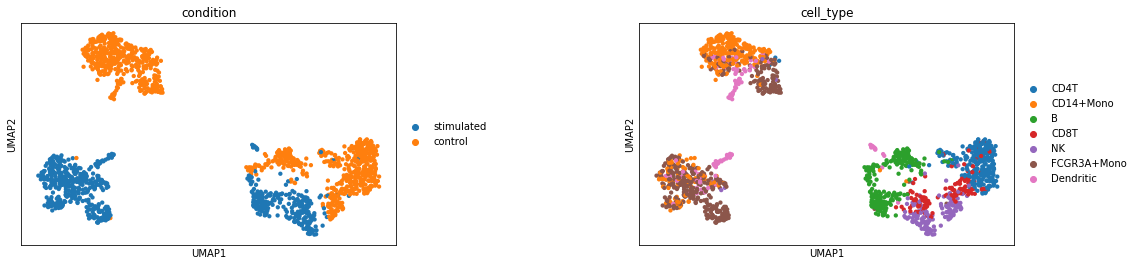

In [8]:
sc.pp.neighbors(validation_new)
sc.tl.umap(validation_new)
sc.pl.umap(validation_new, color=["condition", "cell_type"],  wspace=.5)

Let's now make the scGen object with dimension the dimension of your input data

In [10]:
scg = scgen.VAEArith(x_dimension= train.shape[1], model_path="./models/test" )

We train the model for 150 epochs, Note that providing validation data is "optional" if you do not have one
just ignore it!

In [11]:
scg.train(train_data=train_new, use_validation=True, valid_data=validation_new, n_epochs=100)

After training the model you can pass a the adata of the cells
you want to perturb. Here we pass unperturbed CD4T cells


In [12]:
unperturbed_cd4t = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]


Here 'adata' is the data where you want to infer the perturbation which is the whole train data, we set
"ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context
just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy
matrix of our predicted cells and the second one is the difference vector between our conditions which might
become useful later.

In [13]:
pred, delta = scg.predict(adata= train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim":"stimulated"}) 


In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest which might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells

In [14]:
pred, delta = scg.predict(adata= train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim":"stimulated"}, obs_key={"cell_type": ["CD8T", "NK"]}) 


Alternatively, you can just pass the cell_type name in your adata file (if it exists there under the "cell_type" label) and predict it


In [15]:
pred, delta = scg.predict(adata= train_new, celltype_to_predict="CD4T",
                          conditions={"ctrl": "control", "stim":"stimulated"},
                          obs_key={"cell_type": ["CD8T", "NK"]}) 


We make a anndata file from predicted CD4T cells

In [16]:
pred_adata = sc.AnnData(pred, obs={"condition":["pred"]*len(pred)}, var={"var_names":train.var_names})


Extracting both control and real stimulated CD4T cells from our dataset

In [17]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

Merging predicted cells with real ones 

In [18]:
all_adata = CD4T.concatenate(pred_adata)

Embedding all real and predicted cells in one PCA plot 

... storing 'cell_type' as categorical
... storing 'condition' as categorical


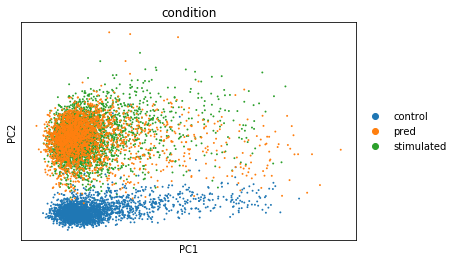

In [19]:
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color="condition")

You can also visualize your mean gene expression of your predicted cells vs control cells while
highlighting your genes of interest

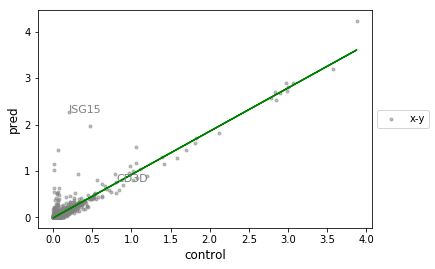

In [20]:
 scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                              axis_keys={"x": "control", "y": "pred"},
                              gene_list=["ISG15", "CD3D"],
                                 path_to_save="tests/figures/reg_mean1.pdf")

You can also use the delta vector explained earlier to build the classifier between
your conditions. You need to pass scgen object and the delta vector

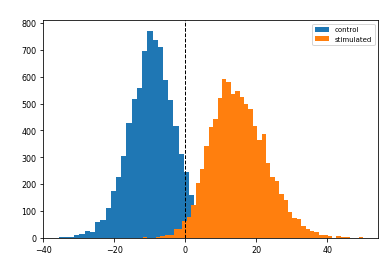

In [21]:
scgen.plotting.binary_classifier(scg, train, delta, condtion_key="condition",
                                     conditions={"ctrl": "control", "stim": "stimulated"},
                                  path_to_save="tests/figures/binary_classifier.pdf")

In [22]:
scg.sess.close()